In [ ]:
''' Identify important content-level video features for each pipeline.
Challenge: 1. many features are highly correlated. how to reduce redundancy.
           2. identify "all" important features.
           
High-level description of our feature selection (two steps):
            1. Remove highly correlated features.
            2. Identify important features using different kinds of feature selection methods.
'''

In [1]:
import os
from collections import defaultdict
import glob
import sys
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel, SelectKBest, mutual_info_regression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestRegressor
from sklearn.linear_model import (LinearRegression, Ridge, 
								  Lasso)
from sklearn.feature_selection import RFE, f_regression
from sklearn.preprocessing import MinMaxScaler
from minepy import MINE
import operator
from mpl_toolkits.mplot3d import Axes3D
from pipeline_performance_loader import initialization, read_feature
from sklearn.base import BaseEstimator, TransformerMixin
from VIF import ReduceVIF
import seaborn as sns
from scipy.stats import pearsonr
from matplotlib import pyplot

In [2]:
# Create our function which stores the feature rankings to the ranks dictionary
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))


def rank_to_dict(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x, 2), ranks)
    return dict(zip(names, ranks ))

def topK_index(data, K):
    indices = data.argsort()[-1*K:][::-1]
    return indices, data[indices]





In [3]:
def feature_filtering(df, filter_method='pearson'):
	# remove correlated features
	if filter_method == 'VIF':
		# filter 
		transformer = ReduceVIF(thresh=5)
		df_filtered = transformer.fit_transform(df)
		return df_filtered
	elif filter_method == 'pearson':
		# filter feateures with pearson correlation higher than a thresh
		corr_matrix = df.corr()
		correlated_features = set()
		thresh = 0.8
		for i in range(len(corr_matrix.columns)):
			for j in range(i):
				if abs(corr_matrix.iloc[i, j]) > thresh:
					colname = corr_matrix.columns[i]
					correlated_features.add(colname)
		df_filtered = df.drop(correlated_features, axis=1)
		return df_filtered

	
	else:
		print('Filter method {} does not exist.'.format(filter_method))
		return df

In [4]:
def NS_parser(path):
    perf = {}
    with open(path, 'r') as f:
        f.readline()
        for line in f:
            line_list = line.strip().split(',')
            f1 = float(line_list[3])
            bw = float(line_list[4])
            gpu = float(line_list[5])
            perf[line_list[0]] = (gpu, f1, bw)

    return perf

def MS_parser(path):
    perf = {}
    with open(path, 'r') as f:
        f.readline()
        for line in f:
            line_list = line.strip().split(',')
            f1 = float(line_list[2])
            gpu = float(line_list[3])
            easy_frame = float(line_list[4])
            perf[line_list[0]] = (gpu, f1, easy_frame)		
    return perf



In [31]:
# Load pipeline performance
all_feature_names, moving, video_to_delete, selected_video, glimpse_video_to_delete = initialization()
path = '../feature_analysis/video_features_30s/'
# feature_file = path + 'features_all_type_width_height_filter.csv'
feature_file = path + 'allvideo_features_long_add_width_20_filter.csv'
features = read_feature(feature_file)

noscope_path = '../noscope/results/Noscope_overfitting_result_allvideo_w_gpu_cost_min_gpu.csv'
noscope_perf = NS_parser(noscope_path)
modelselection_path = '../model_selection/results/model_selection_overfitting_mergelabel.csv'
modelselection_perf = MS_parser(modelselection_path)

easy_frame = pd.read_csv("../model_selection/results/easy_frame_percentage.csv",index_col ='dataset')


driving2_3,0.0,0.0,0,0.0,0.0,0.0,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017777777777777778,0,0.03079506172839507,0.17548521797688565,10.38655522428052,109.89372638584705,0.03079506172839507,0.0,0.0,0.0,0.0,0.0,2.252728336819822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,nan,0.0,0.0,0

driving2_8,0.0,0.0,0,0.0,0.0,0.0,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,nan,0.0,0.0,0

driving2_27,0.0,0.0,0,0.0,0.0,0.0,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,nan,

In [32]:
target_perf = noscope_perf
NUM_OF_FEATURES=2
print(easy_frame.loc['cropped_crossroad5_0']['easy_frame_percentage'])

0.8353726362625139


In [33]:

X = []
y = []
easy_frame_feature = []
key_list = []
for key in sorted(target_perf.keys()):
    if key not in features:
        print('No feature for ', key)
        continue
    dataset_name = key.replace('_' + key.split('_')[-1], '')
    if dataset_name in video_to_delete:
        continue
    # data cleaning
    if features[key][all_feature_names.index('object_cn_avg')] <= 0:
        continue
    if features[key][all_feature_names.index('velocity_avg')] < 1:
        continue
    if features[key][all_feature_names.index('object_size_avg')] <= 0:
        continue
    
#     if target_perf[key][1] < 0.9 or target_perf[key][1] > 0.95:
#         continue
    if 'cropped' in key:
        continue
    X.append(features[key])
    y.append(target_perf[key][0])
    key_list.append(key)
    easy_frame_feature.append(easy_frame.loc[key]['easy_frame_percentage'])

# preprocessing: standardization, and train test split
print('Preprocessing starts (normalization, train_test_split)......')
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)  
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                    test_size=0.2, random_state=0) 

print('Preprocessing done!')

No feature for  driving2_27
No feature for  driving2_3
No feature for  driving2_8
Preprocessing starts (normalization, train_test_split)......
Preprocessing done!


(0.019351408456821217, 0.6918195639033533)


(0, 0.01)

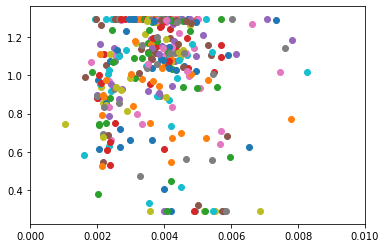

In [34]:
df = pd.DataFrame(X, columns=all_feature_names)
df['perf'] = y
df['easy_frame'] = easy_frame_feature
# for name in all_feature_names:
    
#     plt.scatter(df[name], df['perf'])
#     print(pearsonr(df[name], df['perf']))
#     plt.title(name)
#     plt.show()
print(pearsonr(df['percentage'], df['perf']))
for i in range(0, len(df['percentage'])):
    plt.scatter(df['object_size_percentile10'][i], df['perf'][i])
#     plt.annotate(key_list[i], (df['percentage'][i], df['perf'][i]), rotation=45)
plt.xlim(0, 0.01)

After pearson correlation filtering, remaining features: Index(['object_cn_median', 'object_cn_var', 'object_cn_skewness',
       'object_size_median', 'object_size_mode', 'object_size_skewness',
       'object_size_percentile10', 'object_size_percentile25',
       'arrival_rate_median', 'arrival_rate_mode', 'arrival_rate_var',
       'arrival_rate_skewness', 'arrival_rate_percentile10', 'velocity_median',
       'velocity_mode', 'velocity_skewness', 'total_area_var',
       'number_of_object_classes'],
      dtype='object')
ReduceVIF fit
ReduceVIF transform


/home/zhujunxiao/newenv/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Dropping object_cn_var with vif=inf
Dropping object_cn_percentile25 with vif=inf
Dropping object_size_var with vif=inf
Dropping object_size_percentile25 with vif=inf
Dropping arrival_rate_var with vif=inf
Dropping arrival_rate_percentile25 with vif=inf
Dropping velocity_var with vif=inf
Dropping velocity_percentile25 with vif=inf
Dropping total_area_var with vif=inf
Dropping total_area_percentile25 with vif=inf
Dropping velocity_avg with vif=36346.53648092962
Dropping object_size_entropy with vif=14216.075934584276
Dropping total_area_entropy with vif=10614.10356732406
Dropping total_area_avg with vif=9289.920497599747
Dropping velocity_percentile75 with vif=5818.793944623057
Dropping velocity_entropy with vif=4671.778969854259
Dropping object_size_avg with vif=2464.3619199849863
Dropping object_cn_entropy with vif=1811.564186585106
Dropping object_cn_avg with vif=1781.0064133533087
Dropping arrival_rate_avg with vif=1008.4835466168239
Dropping object_size_percentile75 with vif=770.021

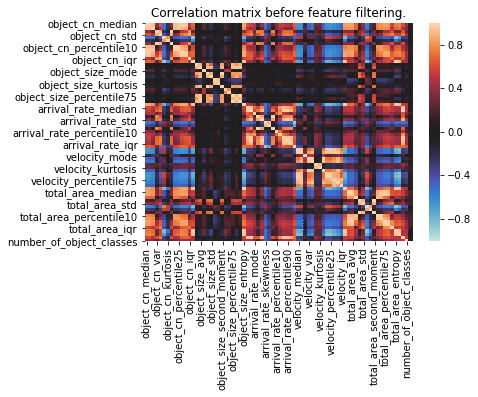

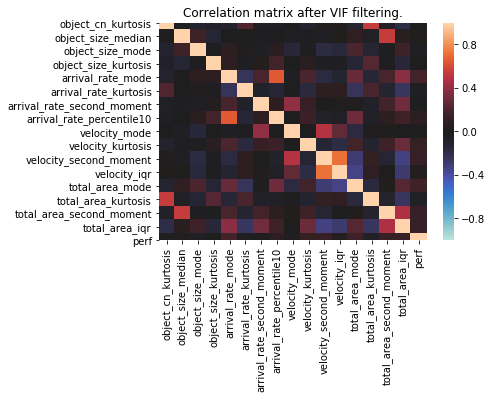

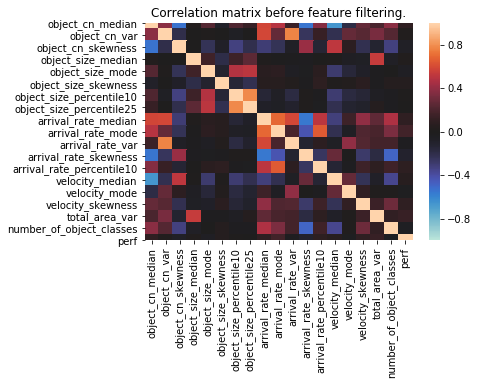

In [35]:
# remove correlated features, using two methods
df = pd.DataFrame(X_train, columns=all_feature_names)
df_filtered_pearson = feature_filtering(df)
print('After pearson correlation filtering, remaining features:', df_filtered_pearson.columns)
df_filtered_vif = feature_filtering(df, filter_method='VIF')
print('After VIF filtering, remaining features:', df_filtered_vif.columns)

# visualize correlation matrix before and after filtering
df['perf'] = y_train
df_filtered_pearson['perf'] = y_train
df_filtered_vif['perf'] = y_train

# f,(ax1,ax2,ax3) = plt.subplots(1,3,sharey=True)
cor = df.corr()
sns.heatmap(cor, vmin=-1, vmax=1, center=0)
plt.title('Correlation matrix before feature filtering.')
plt.show()
cor = df_filtered_vif.corr()
sns.heatmap(cor, vmin=-1, vmax=1, center=0)
plt.title('Correlation matrix after VIF filtering.')
plt.show()
cor = df_filtered_pearson.corr()
sns.heatmap(cor, vmin=-1, vmax=1, center=0)
plt.title('Correlation matrix before feature filtering.')
plt.show()	


In [36]:
# Implement multiple types of feature selection methods. And compare their selected results.

def select_good_features(X, Y, names, n_features_to_select=5):
    ranks = {}
    lr = LinearRegression(normalize=True)
    lr.fit(X, Y)
    ranks["Linear"] = rank_to_dict(np.abs(lr.coef_), names)

    ridge = Ridge(alpha=7)
    ridge.fit(X, Y)
    ranks["Ridge"] = rank_to_dict(np.abs(ridge.coef_), names)


    lasso = Lasso(alpha=.05)
    lasso.fit(X, Y)
    ranks["Lasso"] = rank_to_dict(np.abs(lasso.coef_), names)


    #stop the search when 5 features are left (they will get equal scores)
    rfe = RFE(lr, n_features_to_select=5)
    rfe.fit(X,Y)
    ranks["RFE"] = rank_to_dict(rfe.ranking_, names, order=-1)

    rf = RandomForestRegressor()
    rf.fit(X,Y)
    ranks["RF"] = rank_to_dict(rf.feature_importances_, names)


    f, pval  = f_regression(X, Y, center=True)
    ranks["Corr."] = rank_to_dict(f, names)

    mine = MINE()
    mic_scores = []
    for i in range(X.shape[1]):
        mine.compute_score(X[:,i], Y)
        m = mine.mic()
        mic_scores.append(m)

    ranks["MIC"] = rank_to_dict(mic_scores, names) 
    r = {}
    for name in names:
        r[name] = round(np.mean([ranks[method][name] 
                                 for method in ranks.keys()]), 2)

    methods = sorted(ranks.keys())
    ranks["Mean"] = r
    methods.append("Mean")

  

    # rank = [np.abs(x) for x in lr.feature_importances_]
    # indicies = topK_index(np.asarray(rank), 3)

    # for i in indicies[0]:
    # 	print(all_feature_names[i])

    return methods, ranks





In [37]:
features = df.drop(['perf'], axis=1)
X = features.as_matrix()
Y = df['perf']
print(np.where(np.isnan(X)))
names = features.columns.values
print('The shape of feature matrix:', X.shape)
print('all feature names:', names)
methods, ranks = select_good_features(X, Y, names, n_features_to_select=5)


/home/zhujunxiao/newenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


(array([], dtype=int64), array([], dtype=int64))
The shape of feature matrix: (337, 73)
all feature names: ['object_cn_median' 'object_cn_avg' 'object_cn_mode' 'object_cn_var'
 'object_cn_std' 'object_cn_skewness' 'object_cn_kurtosis'
 'object_cn_seco nd_moment' 'object_cn_percentile10'
 'object_cn_percentile25' 'object_cn_percentile75'
 'object_cn_percentile90' 'object_cn_iqr' 'object_cn_entropy'
 'object_size_median' 'object_size_avg' 'object_size_mode'
 'object_size_var' 'object_size_std' 'object_size_skewness'
 'object_size_kurtosis' 'object_size_second_moment'
 'object_size_percentile10' 'object_size_percentile25'
 'object_size_percentile75' 'object_size_percentile90' 'object_size_iqr'
 'object_size_entropy' 'arrival_rate_median' 'arrival_rate_avg'
 'arrival_rate_mode' 'arrival_rate_var' 'arrival_rate_std'
 'arrival_rate_skewness' 'arrival_rate_kurtosis'
 'arrival_rate_second_moment' 'arrival_rate_percentile10'
 'arrival_rate_percentile25' 'arrival_rate_percentile75'
 'arrival_rat

/home/zhujunxiao/newenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [38]:
print("%30s\t%s" % ('Feature name', "\t".join(methods)))
for name in names:
    print("%30s\t%s" % (name, "\t".join(map(str, 
                         [ranks[method][name] for method in methods])))) 

                  Feature name	Corr.	Lasso	Linear	MIC	RF	RFE	Ridge	Mean
              object_cn_median	0.24	0.0	0.0	0.53	0.0	0.18	0.18	0.16
                 object_cn_avg	0.2	0.0	0.0	0.49	0.02	0.34	0.16	0.17
                object_cn_mode	0.2	0.0	0.0	0.49	0.0	0.32	0.1	0.16
                 object_cn_var	0.02	0.0	0.04	0.44	0.03	0.28	0.01	0.12
                 object_cn_std	0.03	0.0	0.0	0.44	0.11	0.31	0.11	0.14
            object_cn_skewness	0.09	0.0	0.0	0.58	0.1	0.16	0.32	0.18
            object_cn_kurtosis	0.03	0.0	0.0	0.34	0.08	0.01	0.02	0.07
      object_cn_seco nd_moment	0.02	0.0	0.04	0.44	0.02	0.4	0.01	0.13
        object_cn_percentile10	0.23	0.0	0.0	0.54	0.0	0.04	0.06	0.12
        object_cn_percentile25	0.19	0.0	0.01	0.66	0.01	0.43	0.08	0.2
        object_cn_percentile75	0.2	0.0	0.01	0.47	0.0	0.25	0.08	0.14
        object_cn_percentile90	0.17	0.0	0.0	0.41	0.0	0.15	0.21	0.13
                 object_cn_iqr	0.06	0.0	0.01	0.26	0.0	0.26	0.0	0.08
             object_cn_entropy	0.01	0.0	

In [39]:
for method in methods:
    new_rank = {k: v for k, v in sorted(ranks[method].items(), key=lambda item: item[1], reverse=True)}
    rank_iterator = iter(new_rank)
    print('Selected features of method {}:'.format(method))
    for i in range(3):
        selected_feature = next(rank_iterator)
        feature_importance = new_rank[selected_feature]
        print(selected_feature, feature_importance)


Selected features of method Corr.:
total_area_avg 1.0
total_area_percentile90 0.98
total_area_median 0.9
Selected features of method Lasso:
arrival_rate_var 1.0
velocity_kurtosis 0.75
total_area_kurtosis 0.25
Selected features of method Linear:
total_area_var 1.0
total_area_second_moment 1.0
object_size_percentile25 0.46
Selected features of method MIC:
velocity_avg 1.0
velocity_mode 0.97
velocity_percentile90 0.93
Selected features of method RF:
object_size_percentile10 1.0
total_area_kurtosis 0.83
object_size_second_moment 0.7
Selected features of method RFE:
object_size_median 1.0
object_size_var 1.0
object_size_second_moment 1.0
Selected features of method Ridge:
object_size_entropy 1.0
velocity_var 0.67
velocity_std 0.67
Selected features of method Mean:
total_area_avg 0.45
total_area_percentile75 0.44
total_area_percentile25 0.41


In [40]:
features = df_filtered_pearson.drop(['perf'], axis=1)
X = features.as_matrix()
Y = df_filtered_pearson['perf']
names = features.columns.values
print('The shape of feature matrix:', X.shape)
print('all feature names:', names)
methods, ranks = select_good_features(X, Y, names, n_features_to_select=5)


The shape of feature matrix: (337, 18)
all feature names: ['object_cn_median' 'object_cn_var' 'object_cn_skewness'
 'object_size_median' 'object_size_mode' 'object_size_skewness'
 'object_size_percentile10' 'object_size_percentile25'
 'arrival_rate_median' 'arrival_rate_mode' 'arrival_rate_var'
 'arrival_rate_skewness' 'arrival_rate_percentile10' 'velocity_median'
 'velocity_mode' 'velocity_skewness' 'total_area_var'
 'number_of_object_classes']


/home/zhujunxiao/newenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/zhujunxiao/newenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [41]:
print("%30s\t%s" % ('Feature name', "\t".join(methods)))
for name in names:
    print("%30s\t%s" % (name, "\t".join(map(str, 
                         [ranks[method][name] for method in methods])))) 

                  Feature name	Corr.	Lasso	Linear	MIC	RF	RFE	Ridge	Mean
              object_cn_median	0.35	1.0	0.0	0.54	0.24	0.62	0.07	0.4
                 object_cn_var	0.03	0.0	0.0	0.45	0.41	0.0	0.06	0.14
            object_cn_skewness	0.14	0.0	0.0	0.59	0.4	0.54	0.08	0.25
            object_size_median	0.02	0.0	0.06	0.26	0.35	1.0	0.02	0.24
              object_size_mode	0.08	0.0	0.17	0.46	0.24	1.0	0.03	0.28
          object_size_skewness	0.07	0.0	0.0	0.54	0.3	0.23	0.05	0.17
      object_size_percentile10	0.0	0.0	1.0	0.65	1.0	1.0	0.0	0.52
      object_size_percentile25	0.0	0.0	0.1	0.44	0.22	1.0	0.0	0.25
           arrival_rate_median	0.34	0.0	0.0	0.41	0.01	0.15	0.09	0.14
             arrival_rate_mode	1.0	0.0	0.0	0.27	0.0	0.85	0.33	0.35
              arrival_rate_var	0.03	0.19	0.0	0.29	0.2	0.08	0.02	0.12
         arrival_rate_skewness	0.31	0.0	0.0	0.16	0.22	0.31	0.04	0.15
     arrival_rate_percentile10	0.28	0.0	0.0	0.0	0.0	0.69	0.31	0.18
               velocity_median	0.14	0.0	0.01	0

In [42]:
for method in methods:
    new_rank = {k: v for k, v in sorted(ranks[method].items(), key=lambda item: item[1], reverse=True)}
    rank_iterator = iter(new_rank)
    print('Selected features of method {}:'.format(method))
    for i in range(3):
        selected_feature = next(rank_iterator)
        feature_importance = new_rank[selected_feature]
        print(selected_feature, feature_importance)

Selected features of method Corr.:
arrival_rate_mode 1.0
total_area_var 0.58
object_cn_median 0.35
Selected features of method Lasso:
object_cn_median 1.0
velocity_skewness 0.63
arrival_rate_var 0.19
Selected features of method Linear:
object_size_percentile10 1.0
total_area_var 1.0
object_size_mode 0.17
Selected features of method MIC:
velocity_mode 1.0
velocity_median 0.74
object_size_percentile10 0.65
Selected features of method RF:
object_size_percentile10 1.0
total_area_var 0.55
velocity_skewness 0.54
Selected features of method RFE:
object_size_median 1.0
object_size_mode 1.0
object_size_percentile10 1.0
Selected features of method Ridge:
velocity_median 1.0
number_of_object_classes 0.4
arrival_rate_mode 0.33
Selected features of method Mean:
object_size_percentile10 0.52
total_area_var 0.5
velocity_median 0.47


In [43]:
features = df_filtered_vif.drop(['perf'], axis=1)
X = features.as_matrix()
Y = df_filtered_vif['perf']
names = features.columns.values
print('The shape of feature matrix:', X.shape)
print('all feature names:', names)
methods, ranks = select_good_features(X, Y, names, n_features_to_select=5)


The shape of feature matrix: (337, 16)
all feature names: ['object_cn_kurtosis' 'object_size_median' 'object_size_mode'
 'object_size_kurtosis' 'arrival_rate_mode' 'arrival_rate_kurtosis'
 'arrival_rate_second_moment' 'arrival_rate_percentile10' 'velocity_mode'
 'velocity_kurtosis' 'velocity_second_moment' 'velocity_iqr'
 'total_area_mode' 'total_area_kurtosis' 'total_area_second_moment'
 'total_area_iqr']


/home/zhujunxiao/newenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/zhujunxiao/newenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [44]:
print("%30s\t%s" % ('Feature name', "\t".join(methods)))
for name in names:
    print("%30s\t%s" % (name, "\t".join(map(str, 
                         [ranks[method][name] for method in methods])))) 

                  Feature name	Corr.	Lasso	Linear	MIC	RF	RFE	Ridge	Mean
            object_cn_kurtosis	0.05	0.0	0.0	0.35	0.34	0.18	0.0	0.13
            object_size_median	0.02	0.0	0.04	0.26	1.0	1.0	0.04	0.34
              object_size_mode	0.08	0.0	0.15	0.46	0.72	1.0	0.03	0.35
          object_size_kurtosis	0.0	0.0	0.0	0.39	0.36	0.27	0.0	0.15
             arrival_rate_mode	1.0	0.0	0.0	0.27	0.07	0.64	0.43	0.34
         arrival_rate_kurtosis	0.09	0.0	0.0	0.09	0.54	0.45	0.0	0.17
    arrival_rate_second_moment	0.03	1.0	0.0	0.29	0.47	0.36	0.0	0.31
     arrival_rate_percentile10	0.28	0.0	0.0	0.0	0.0	0.73	0.2	0.17
                 velocity_mode	0.05	0.0	0.0	1.0	0.07	0.55	0.14	0.26
             velocity_kurtosis	0.51	0.75	0.0	0.27	0.64	0.0	0.0	0.31
        velocity_second_moment	0.58	0.0	0.01	0.79	0.7	0.91	1.0	0.57
                  velocity_iqr	0.06	0.0	0.0	0.76	0.79	0.82	0.35	0.4
               total_area_mode	0.89	0.0	0.08	0.39	0.21	1.0	0.43	0.43
           total_area_kurtosis	0.14	0.25	0.0	

In [45]:
for method in methods:
    new_rank = {k: v for k, v in sorted(ranks[method].items(), key=lambda item: item[1], reverse=True)}
    rank_iterator = iter(new_rank)
    print('Selected features of method {}:'.format(method))
    for i in range(3):
        selected_feature = next(rank_iterator)
        feature_importance = new_rank[selected_feature]
        print(selected_feature, feature_importance)

Selected features of method Corr.:
arrival_rate_mode 1.0
total_area_mode 0.89
velocity_second_moment 0.58
Selected features of method Lasso:
arrival_rate_second_moment 1.0
velocity_kurtosis 0.75
total_area_kurtosis 0.25
Selected features of method Linear:
total_area_second_moment 1.0
object_size_mode 0.15
total_area_mode 0.08
Selected features of method MIC:
velocity_mode 1.0
velocity_second_moment 0.79
velocity_iqr 0.76
Selected features of method RF:
object_size_median 1.0
velocity_iqr 0.79
object_size_mode 0.72
Selected features of method RFE:
object_size_median 1.0
object_size_mode 1.0
total_area_mode 1.0
Selected features of method Ridge:
velocity_second_moment 1.0
arrival_rate_mode 0.43
total_area_mode 0.43
Selected features of method Mean:
velocity_second_moment 0.57
total_area_second_moment 0.48
total_area_mode 0.43


In [46]:
from scipy.stats import pearsonr

features = df.drop(['perf'], axis=1)
X = features.as_matrix()
Y = df['perf']
names = features.columns.values
correlation_thresh = 0.3
correlated_features = []
for name in names:
    (r, p) = pearsonr(df[name], df['perf'])
    if np.abs(r) > correlation_thresh:
        correlated_features.append((name,r))
correlated_features.sort(key=lambda x: x[1], reverse=True)
print(correlated_features)
selected_features = [correlated_features[0][0]]
for feature in correlated_features[1:]:
    (r, p) = pearsonr(df[feature[0]], df[correlated_features[0][0]])
    if np.abs(r) <= 0.8:
        selected_features.append(feature[0])
print('Final selected feature:', selected_features)

[]


/home/zhujunxiao/newenv/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


IndexError: list index out of range